<a href="https://colab.research.google.com/github/AlexSwiderski/SwiderskiLakhani/blob/main/WPM_10_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primary objectives:
-1. Run current model with 100% of the data.  The model is a proof on concept and intended to be tested on data it was trained on, but with noise inserted into the model.  See objectives below. 

2.1. Create a function to convert the model output to the exact format as the "words" matrix below. name the function to convert the data **out_to_arp** 

2.2. Convert the output of the ANN to create a matrix in the **exact format** as the "words" matrix below.

3.1 Save the current ANN model as "WordProd" so that it can be tested on a subsets of the data it was trained on.  **I recogonize this is not typical for ANN models, but it is 100% necessary for this project**

3.2. Test the WordProd model on the following data from the "test" command below. Plot test accuracy and loss as in the original model, because the original model was trained on this, the model should have accuracy near ceiling.

4.  Convert the output of  "WordProd" to create a matrix in the **exact format** as the "words" matrix below using the previously created 
**out_to_arp** function. Name this m atrix, PNT_output.

5. Create a unique function to add noise to each hidden layer. If possible, gaussian noise. 

6. Create example of how to test accuracy of the WordProd model on the "test" data after inserting noise.  Plot test accuracy and loss as in the original model, accuracy is now expected to perform NOT at ceiling. Make sure to test on the "test" words only.

7. Convert the output of the "WordProd" with added noise to  a matrix in the **exact format** as the "words" matrix below using the previously created **out_to_arp** function. Name the output, Noisy_output 



In [ ]:
test = 'https://raw.githubusercontent.com/AlexSwiderski/SwiderskiLakhani/main/PNT_TEST.csv'

The purpose of this notebook is to create a deep learning model that predicts sound/letter sequences from 300 dimensional word embeddings extracted from GLOVE. The current architecture includes 2 bidirectional recurrent layers and a fully connected hidden layer.

Originally, I planned for the output layer to be similar to the following image:
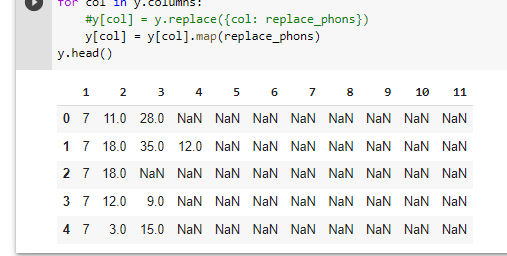

In this matrix, each number corresponds to a letter and each word is represented by a series of numbers in each row vector. However, it occurred to me that using a crossentropy loss function would be better for this multi-label classification problem.  Therefore, I now must transform the row vectors into one-hot-encoded vectors and this is where I need help.

I will outline questions throughout the code below.


### Load required packages

In [ ]:
!pip install torchtext==0.4.0 --quiet
!pip install unidecode --quiet
!pip install d2l --quiet
!pip install nltk --quiet

# Imports
import time
import copy
import torch
import pathlib
import numpy as np
import pandas as pd
from pandas import DataFrame
import gensim
from gensim.matutils import corpus2csc
from gensim.corpora import Dictionary
import pandas as pd
import numpy as np
from sklearn import preprocessing 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm
#import pdb



import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tqdm.auto import tqdm
from IPython.display import HTML
from torchvision import transforms
%unload_ext google.colab.data_table


     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 235 kB 8.4 MB/s 
     |████████████████████████████████| 83 kB 1.6 MB/s 
The google.colab.data_table extension is not loaded.


In [ ]:
# Imports
import math
import time
import nltk
import random
import collections

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F

from torchtext import data, datasets

from d2l import torch as d2l

## Load data, format colums etc.
### Columns 1:11 will be the output layer of the ANN and it will need to be transformed to one-hot-encoded vectors.

In [ ]:
#ChNGED TO MATCH NEW INPUT WORDS
#url = 'https://raw.githubusercontent.com/AlexSwiderski/SwiderskiLakhani/main/Just_Item_Names.csv'
url = 'https://raw.githubusercontent.com/AlexSwiderski/SwiderskiLakhani/main/UpdatedWordList.csv'
words = pd.read_csv(url)
words.fillna('', inplace = True)
words.columns = ['Word', '1', '2', '3', '4', '5', '6','7', '8', '9', '10', '11']
#df = DataFrame(words, columns= ['Word'])
#df_list = df.values.tolist()
#print(df_list)
words

,Word,1,2,3,4,5,6,7,8,9,10,11
0,bear,B,EH,R,,,,,,,,
1,beaver,B,IY,V,ER,,,,,,,
2,bee,B,IY,,,,,,,,,
3,bird,B,ER,D,,,,,,,,
4,bug,B,AH,G,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
1350,flower,F,L,AW,ER,,,,,,,
1351,mountain,M,AW,N,T,AH,N,,,,,
1352,tree,T,R,IY,,,,,,,,
1353,volcano,V,AA,L,K,EY,N,OW,,,,


## Clean data a little

In [ ]:
#drop last empty row in words
# Drop last 3 rows of dataframe
N = 1
words.drop(index=words.index[-N], 
        axis=0, 
        inplace=True)

## Below is a clear representation of what the output data looks like. Note that the first column 'word' will not be included in the output layer.  However, the letter sequences representing each word can be clearly seen.
### Again, columns 1:11 will be the output layer, but need to first be transformed to one hot encoded vectors.

In [ ]:
words

,Word,1,2,3,4,5,6,7,8,9,10,11
0,bear,B,EH,R,,,,,,,,
1,beaver,B,IY,V,ER,,,,,,,
2,bee,B,IY,,,,,,,,,
3,bird,B,ER,D,,,,,,,,
4,bug,B,AH,G,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
1349,map,M,AE,P,,,,,,,,
1350,flower,F,L,AW,ER,,,,,,,
1351,mountain,M,AW,N,T,AH,N,,,,,
1352,tree,T,R,IY,,,,,,,,


## Now i will create a matrix, X, that I will utilize to extract 300d GLOVE word embeddings for each word to utilize as input to the model.

In [ ]:
#phon = pd.read_csv('Words w transcription.csv')
phon_url = 'https://raw.githubusercontent.com/AlexSwiderski/SwiderskiLakhani/main/UpdatedWordList.csv'
phon = pd.read_csv(phon_url)
phon.fillna('0', inplace = True)
phon.columns = ['Word', '1', '2', '3', '4', '5', '6','7', '8', '9', '10', '11']
phon = phon.iloc[:-1 , :]
X = words['Word']
X.head()

0      bear
1    beaver
2       bee
3      bird
4       bug
Name: Word, dtype: object

## Next we load the glove-wiki-gigaworld data set that includes the 300d embeddings.  This takes about 5 min. 

In [ ]:
#Method 1: Get word embeddings for all available words from Wikigigaworld.
import gensim.downloader as api
# Download dataset
glove_model300 = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


## Here I create a matrix X2 that includes the 300d word embeddings for each item.

In [ ]:
#word_array = np.empty((0, 300))
X2 = []
yfound = []
for idx, row in enumerate(X):
    try:
        word_array = np.empty((0, 300))
        result = glove_model300.word_vec(row)
        word_array = np.append(word_array, [result], axis = 0)
        X[idx] = result
        X2.append(result)
        #yfound.append(row[0:14])
        #print(X2)
    except:
         #X[idx] = 'None'
        pass

## Below I create an integer representation of each sound included in the 'words' matrix.  I originally planned to model the output for the DNN with these representations. However, to utilize cross entropy loss with a multi-label classification problem this seems to be causing problems. 

### **This code should not be included in the output layer of the ANN,** but I would like to keep it in the notebook for now as reference for later.

In [ ]:
#original plan, unclear if this is the right way to go.
replace_phons = {'':0,
'AA' :1,

'AE' :2,

'AH' :3,

'AO' :4,

'AW' :5,

'AY' :6,

'B' :7,

'CH' :8,

'D' :9,

'DH' :10,

'EH' :11,

'ER' :12,

'EY' :13,

'F' :14,

'G' :15,

'HH' :16,

'IH' :17,

'IY' :18,

'JH' :19,

'K' :20,

'L' :21,

'M' :22,

'N' :23,

'NG' :24,

'OW' :25,

'OY' :26,

'P' :27,

'R' :28,

'S' :29,

'SH' :30,

'T' :31,

'TH' :32,

'UH' :33,

'UW' :34,

'V' :35,

'W' :36,

'Y' :37,

'Z' :38,

'ZH' :39}

## y is intended to become the outcome for the DNN

In [ ]:
#sorted_data
phon.columns = ['Word', '1', '2', '3', '4', '5', '6','7', '8', '9', '10', '11']
#phon = phon.iloc[:-1 , :]
y = phon
y = y.drop('Word', axis = 1)
y.shape

(1354, 11)

In [ ]:
y

,1,2,3,4,5,6,7,8,9,10,11
0,B,EH,R,0,0,0,0,0,0,0,0
1,B,IY,V,ER,0,0,0,0,0,0,0
2,B,IY,0,0,0,0,0,0,0,0,0
3,B,ER,D,0,0,0,0,0,0,0,0
4,B,AH,G,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1349,M,AE,P,0,0,0,0,0,0,0,0
1350,F,L,AW,ER,0,0,0,0,0,0,0
1351,M,AW,N,T,AH,N,0,0,0,0,0
1352,T,R,IY,0,0,0,0,0,0,0,0


## This for loop creates the integer representation of my initial outcome layer.
### **DO NOT MAKE THE ONE-HOT ENCODED VECTORS OUT OF THIS MATRIX**

In [ ]:
for col in y.columns: 
    # apply the replace_phons dictionary on y each column except word & fill nan values with 0's
    y[col] = y[col].map(replace_phons).fillna(0)
y.head()

,1,2,3,4,5,6,7,8,9,10,11
0,7,11.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,18.0,35.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,12.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,3.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import torch
import torch.nn.functional as F

# convert the indexed numpy array into torch tensor with int64 dtype
y_tensor = torch.tensor( y.values , dtype=torch.int64 )
# troech tensor one hot encoding
y_one_hot_encoding = F.one_hot(y_tensor, num_classes=40)

In [ ]:
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

  # @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

## Set seed and device

In [ ]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.


## Create custom data set

In [ ]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, dat, labels):
        self.labels = labels
        self.dat = dat

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        dat = self.dat[idx]
        sample = {"Sample": dat, "Class": label}
        return sample


In [ ]:
X2 = np.array(X2)
#y = np.array(y)
X2 = torch.from_numpy(X2)
y = y_one_hot_encoding

## Defiing parameters for the RNN and creating the train and validation set.  I know that the train/test are the same right now.  That is fine and I will play with that later. As long as they both run, that will be sufficient. 

In [ ]:
# Splitting dataset
# Uncler what the batch size should be
batch_size = 11
# get the indices for the index for the dataset
index_set = np.arange( len(y) )
# shuffle the indices
random.shuffle( index_set )
# define train , val split as 0.8 train , 0.2 valid
train_val_split = 0.2
train_limit = int( train_val_split * len(y)  )
# extract train and validation indices
train_index , val_index = index_set[ train_limit : ] , index_set[:train_limit]

# define train and validation datasets 
x_train , y_train = X2[ train_index ] , y[ train_index ]
x_valid , y_valid = X2[ val_index ] , y[ val_index ]

# define data loaders for each train and test 
train_dset = CustomDataset( x_train , y_train )  # create data set
train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True) #load data with batch size
valid_dset = CustomDataset( x_valid , y_valid )
valid_loader = DataLoader(valid_dset, batch_size=batch_size, shuffle=True)

g_seed = torch.Generator()
g_seed.manual_seed(SEED)


In [ ]:
# Imports
import math
import time
import nltk
import random
import collections

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F

from torchtext import data, datasets
from torch.utils.data import Dataset, DataLoader

from d2l import torch as d2l

In [ ]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(VanillaRNN, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = True
        self.decoder_length = 11
        self.input_size = input_size

        #Defining the layers
        # input encoder model --> which used to map the input size to match with hidden_dim
        self.encoder_input = nn.Linear( self.input_size , hidden_dim )
        # RNN Layer
        self.rnn = nn.RNN( hidden_dim , hidden_dim, n_layers, batch_first=True, bidirectional = self.bidirectional) 
        # if rnn model is bidirectional then output troech tensor stacked forward and backward vectors
        if( self.bidirectional ): 
          # use decoder dense layer to reduce the channel size to hidden_dim since decoder working in reccursive way 
          self.decoder_dense = nn.Linear( hidden_dim*2 , hidden_dim ) 

        else:
          self.decoder_dense = nn.Linear( hidden_dim , hidden_dim ) 

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim , output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)
        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        outputs = torch.zeros( batch_size , self.decoder_length , self.hidden_dim )
        # encode input vector  (input_size --> hidden_dim)
        x = self.encoder_input( x )

        # decoder working as reccursive way , output need to have 11 predictions in reccursive way
        for t in range( self.decoder_length ): 
            # forward pass the rnn layer and output one time step prediction and hidden tensor
            decoder_output, hidden = self.rnn( x , hidden )
            # map the cocatenated bidrectional vector into hidden_dim
            decoder_output = self.decoder_dense( decoder_output.squeeze(1) )
           
            # stck the outputs
            outputs[:,t,:] = decoder_output
            x = decoder_output.unsqueeze(1)

        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(outputs)
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        if(self.bidirectional ):
          hidden = torch.zeros(self.n_layers*2, batch_size, self.hidden_dim, device = DEVICE)
          return hidden
        else:
          hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim, device = DEVICE)
        return hidden

In [ ]:
def plot_train_val(x, train, val, train_label,
                   val_label, title, y_label,
                   color):
  fig = plt.figure( figsize=(6,6) )
  plt.plot(x, train, label=train_label, color=color)
  plt.plot(x, val, label=val_label, color=color, linestyle='--')
  plt.legend(loc='lower right')
  plt.xlabel('epoch')
  plt.ylabel(y_label)
  plt.title(title)
  plt.show()


def count_parameters(model):
  parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return parameters


def init_weights(m):
  if type(m) in (nn.Linear, nn.Conv1d):
    nn.init.xavier_uniform_(m.weight)



# Training functioN
def train(model, device, train_loader, valid_loader, epochs, learning_rate):

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []

  for epoch in range(epochs):
    #train
    model.train()
    running_loss = 0.
    correct, total = 0, 0
    steps = 0
    for idx, batch in enumerate(train_loader):
      text = batch["Sample"].to(device)
      target = batch['Class'].to(device)
      target = target.type(torch.LongTensor)
      text, target = text.to(device), target.to(device)
      # add micro for coding training loop
      optimizer.zero_grad()
      output, hidden = model(text.unsqueeze(1))

      #pdb.set_trace()
      #print(output.shape, target.shape, target.view(-1).shape)

      # reshape the output and target as 2d vector which accepted by the cross_entropy loss
      loss = criterion( output.contiguous().view(-1,target.shape[-1]) , torch.max( target , 2)[1].view(-1) )
      loss.backward()
      optimizer.step()
      steps += 1
      running_loss += loss.item()

      # get accuracy
      _, predicted = torch.max(output, 2)
      #print(predicted)
      #predicted = torch.round(output.squeeze())
      total += target.size(0)*target.size(1)
      correct += (predicted == torch.max(target,2)[1]  ).sum().item()

    train_loss.append(running_loss/len(train_loader))
    train_acc.append(correct/total)

    print(f'Epoch: {epoch + 1}, '
          f'Training Loss: {running_loss/len(train_loader):.4f}, '
          f'Training Accuracy: {100*correct/total: .2f}%')

    # evaluate on validation data
    model.eval()
    running_loss = 0.
    correct, total = 0, 0

    with torch.no_grad():
      for idx, batch in enumerate(valid_loader):
        text = batch["Sample"].to(device)
        #print(type(text), text.shape)
        target = batch['Class'].to(device)
        target = torch.autograd.Variable(target).long()
        text, target = text.to(device), target.to(device)

        optimizer.zero_grad()
        output , _ = model(text.unsqueeze(1))
        
        loss = criterion(output.contiguous().view(-1,target.shape[-1]) , torch.max( target , 2)[1].view(-1) )
        running_loss += loss.item()

        # get accuracy
        _, predicted = torch.max(output, 2)
        #predicted = torch.round(output.squeeze())
        total += target.size(0)*target.size(1)
        correct += (predicted == torch.max(target,2)[1] ).sum().item()

    validation_loss.append(running_loss/len(valid_loader))
    validation_acc.append(correct/total)

    print (f'Validation Loss: {running_loss/len(valid_loader):.4f}, '
           f'Validation Accuracy: {100*correct/total: .2f}%\n')

  return train_loss, train_acc, validation_loss, validation_acc

Random seed 2021 has been set.
Epoch: 1, Training Loss: 1.9568, Training Accuracy:  53.56%
Validation Loss: 1.7189, Validation Accuracy:  57.47%

Epoch: 2, Training Loss: 1.7321, Training Accuracy:  55.91%
Validation Loss: 1.6310, Validation Accuracy:  57.78%

Epoch: 3, Training Loss: 1.6730, Training Accuracy:  56.11%
Validation Loss: 1.6385, Validation Accuracy:  58.25%

Epoch: 4, Training Loss: 1.6624, Training Accuracy:  56.37%
Validation Loss: 1.6604, Validation Accuracy:  57.47%

Epoch: 5, Training Loss: 1.6424, Training Accuracy:  56.47%
Validation Loss: 1.6006, Validation Accuracy:  58.59%

Epoch: 6, Training Loss: 1.6249, Training Accuracy:  56.83%
Validation Loss: 1.6085, Validation Accuracy:  58.22%

Epoch: 7, Training Loss: 1.6078, Training Accuracy:  57.00%
Validation Loss: 1.6210, Validation Accuracy:  58.01%

Epoch: 8, Training Loss: 1.5982, Training Accuracy:  57.30%
Validation Loss: 1.6607, Validation Accuracy:  57.95%

Epoch: 9, Training Loss: 1.6161, Training Accurac

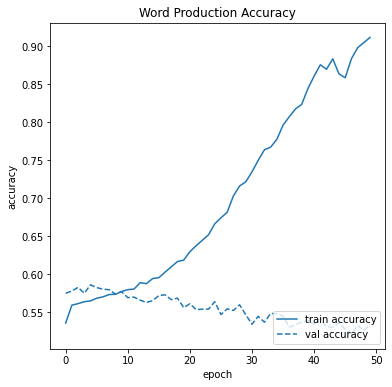

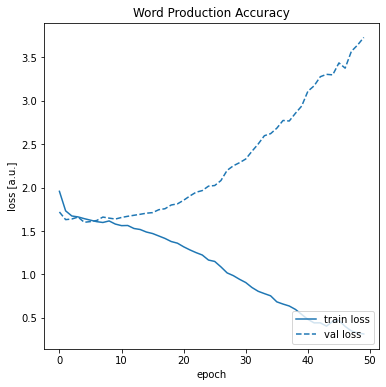

In [ ]:
# Model hyperparamters
#vocab_size = len(word_array)
learning_rate = 1e-3
hidden_dim = 100
output_size = 40
input_size = 300
epochs = 50
n_layers = 2

# Initialize model, training and testing
set_seed(SEED)
vanilla_rnn_model = VanillaRNN(input_size, output_size, hidden_dim, n_layers)
#vanilla_rnn_model = VanillaRNN(output_size, input_size, RNN_size, fc_size, DEVICE)
vanilla_rnn_model.to(DEVICE)
vanilla_rnn_start_time = time.time()
vanilla_train_loss, vanilla_train_acc, vanilla_validation_loss, vanilla_validation_acc = train(vanilla_rnn_model,
                                                                                               DEVICE,
                                                                                               train_loader,
                                                                                               valid_loader,
                                                                                               epochs = epochs,
                                                                                               learning_rate = learning_rate)
print("--- Time taken to train = %s seconds ---" % (time.time() - vanilla_rnn_start_time))


# Number of model parameters
print(f'Number of parameters = {count_parameters(vanilla_rnn_model)}')


# Plot accuracy curves

plot_train_val(np.arange(0, epochs), vanilla_train_acc, vanilla_validation_acc,
               'train accuracy', 'val accuracy',
               'Word Production Accuracy', 'accuracy',
               color='C0')


plot_train_val(np.arange(0, epochs), vanilla_train_loss,
               vanilla_validation_loss,
               'train loss', 'val loss',
               'Word Production Accuracy',
               'loss [a.u.]',
               color='C0')

